In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to C:\Users\Hesham
[nltk_data]     Hanie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Data Reading and Info

In [3]:
df = pd.read_csv('./train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Missing Data

In [5]:
num_rows, num_features = df.shape
df.apply(lambda x: [x.isna().sum(), x.isna().sum()/num_rows * 100], axis=0).set_index(pd.Series(["# of missing data", "Percentage"]))

,id,keyword,location,text,target
# of missing data,0.0,61.000000,2533.000000,0.0,0.0
Percentage,0.0,0.801261,33.272035,0.0,0.0


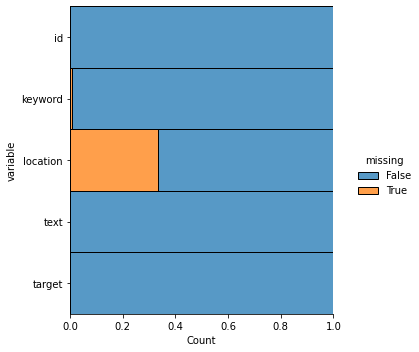

In [6]:
sns.displot(data=df.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", aspect=1) 
plt.show()

# How many data in each class?

In [7]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

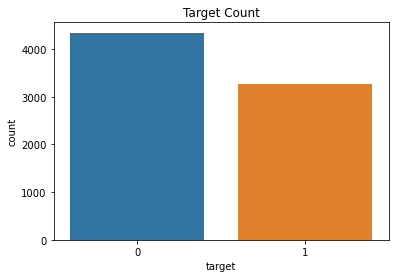

In [8]:
sns.countplot(x="target", data=df).set(title="Target Count")
plt.show()

# Top 15 Locations

In [9]:
locations = df["location"].value_counts()
locations[0:15]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64

# Top 15 Keywords

In [10]:
keywords = df["keyword"].value_counts()
keywords[0:15]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64

# Most Common Words

In [13]:
import collections
from collections import Counter

word_count = Counter(" ".join(df["text"]).split())
words = word_count.most_common(10)
words

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('I', 1197),
 ('for', 820),
 ('is', 814),
 ('on', 773)]

In [15]:
stop_words = stopwords.words('english')
stop = {word: word_count[word] for word in word_count if word in stop_words}
common_stop_words = sorted(stop.items(), key=lambda x: x[1], reverse=True)
common_stop_words[:10]

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('for', 820),
 ('is', 814),
 ('on', 773),
 ('you', 632)]

# Prepare Data Set

Concatenate Keyword & Text


In [16]:
def concat(row):
    if type(row) != list:
        row = row.to_list()
    x, y = row[0], row[1]
    new_cell = x + " " + y if isinstance(x, str) else y
    return new_cell

In [18]:
df["Key_Text"] = df.loc[:, ["keyword", "text"]].apply(concat, axis=1)
df

,id,keyword,location,text,target,Key_Text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...


Remove Stop Words

In [19]:
def remove_stop_words(text):
    tokens = [token.lower() for token in text.split() if token.lower() not in stop_words]
    return " ".join(tokens)

Remove Numbers

In [20]:
def remove_number(text):
    return ''.join([ele for ele in text if not ele.isdigit()])

Stemming

In [21]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
def stem(text):
    return ''.join([ps.stem(ele) for ele in text])

Remove Punctuation

In [22]:
import string

def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))

Final Preperation

In [23]:
def PrepareData(text):
    text = remove_stop_words(text)
    text = remove_number(text)
    text = stem(text)
    text = remove_punctuation(text)
    return text

In [25]:
df["NLP"] = df["Key_Text"].apply(PrepareData)
df

,id,keyword,location,text,target,Key_Text,NLP
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,ariaahrary thetawniest control wild fires cali...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m utckm volcano hawaii httptcozdtoydebj
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,police investigating ebike collided car little...


# Tokenization

In [26]:
import nltk
nltk.download('punkt')
df["NLP"] = df["NLP"].apply(lambda text: word_tokenize(text))
df

[nltk_data] Downloading package punkt to C:\Users\Hesham
[nltk_data]     Hanie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,keyword,location,text,target,Key_Text,NLP
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,"[two, giant, cranes, holding, bridge, collapse..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,"[ariaahrary, thetawniest, control, wild, fires..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,"[m, utckm, volcano, hawaii, httptcozdtoydebj]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,"[police, investigating, ebike, collided, car, ..."


In [27]:
from sklearn.model_selection import train_test_split

X = df["NLP"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

print("X_train shape= ", X_train.shape)
print("y_train shape= ", y_train.shape)

print("X_test shape= ", X_test.shape)
print("y_test shape= ", y_test.shape)

X_train shape=  (5329,)
y_train shape=  (5329,)
X_test shape=  (2284,)
y_test shape=  (2284,)


Vocabulary size

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Vocabulary Size:  16990


# Padding

In [29]:
seq_len = 50

X_train_pad = pad_sequences(X_train_seq, maxlen=seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=seq_len)
X_train_pad

array([[    0,     0,     0, ...,  5174,  3375,   138],
       [    0,     0,     0, ...,   342,  2075,   165],
       [    0,     0,     0, ...,  5179,   816,     8],
       ...,
       [    0,     0,     0, ...,    50,    11,  3314],
       [    0,     0,     0, ..., 16986, 16987, 16988],
       [    0,     0,     0, ...,  1031,  2448,   123]])

# Model Structure

In [30]:
embedding_dim = 32

mdl = Sequential()

mdl.add(Embedding(vocab_size, embedding_dim, input_length=seq_len))
mdl.add(LSTM(64, dropout=0.1))
mdl.add(Dense(1, activation="sigmoid"))

mdl.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            543680    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 568,577
Trainable params: 568,577
Non-trainable params: 0
_________________________________________________________________


Train

In [31]:
mdl.fit(X_train_pad, y_train, epochs=20, validation_data=(X_test_pad, y_test))

Epoch 1/20
167/167 [==============================] - 6s 25ms/step - loss: 0.5774 - accuracy: 0.6866 - val_loss: 0.4446 - val_accuracy: 0.7885
Epoch 2/20
167/167 [==============================] - 3s 20ms/step - loss: 0.3109 - accuracy: 0.8788 - val_loss: 0.4573 - val_accuracy: 0.7881
Epoch 3/20
167/167 [==============================] - 3s 20ms/step - loss: 0.1618 - accuracy: 0.9407 - val_loss: 0.5310 - val_accuracy: 0.7898
Epoch 4/20
167/167 [==============================] - 3s 20ms/step - loss: 0.0877 - accuracy: 0.9690 - val_loss: 0.5965 - val_accuracy: 0.7811
Epoch 5/20
167/167 [==============================] - 3s 21ms/step - loss: 0.0518 - accuracy: 0.9829 - val_loss: 0.7454 - val_accuracy: 0.7741
Epoch 6/20
167/167 [==============================] - 4s 23ms/step - loss: 0.0333 - accuracy: 0.9891 - val_loss: 0.8244 - val_accuracy: 0.7684
Epoch 7/20
167/167 [==============================] - 3s 20ms/step - loss: 0.0282 - accuracy: 0.9910 - val_loss: 0.8189 - val_accuracy: 0.7636

Test

In [32]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
df_test["Key_Text"] = df_test.loc[:, ["keyword", "text"]].apply(concat, axis=1)
df_test["NLP"] = df_test["Key_Text"].apply(PrepareData)
df_test["NLP"] = df_test["NLP"].apply(lambda text: word_tokenize(text))
df_test

,id,keyword,location,text,Key_Text,NLP
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...","[heard, earthquake, different, cities, stay, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, china, taiwan]"
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,"[earthquake, safety, los, angeles, ûò, safety..."
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My city...,"[storm, ri, worse, last, hurricane, cityampoth..."
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co/U...,"[green, line, derailment, chicago, httptcoutbx..."
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO) htt...,"[meg, issues, hazardous, weather, outlook, hwo..."


In [34]:
X_test_test = df_test["NLP"]
X_test_test
X_test_test_seq = tokenizer.texts_to_sequences(X_test_test)
X_test_test_pad = pad_sequences(X_test_test_seq, maxlen=seq_len)

In [35]:
predicted = mdl.predict(X_test_test_pad)
predicted

102/102 [==============================] - 1s 5ms/step


array([[1.3868175e-04],
       [1.8784626e-01],
       [9.9999917e-01],
       ...,
       [9.9702299e-01],
       [9.9997658e-01],
       [9.9305081e-01]], dtype=float32)

In [36]:
df_test.drop(["NLP", "Key_Text"], axis=1, inplace=True)
df_test["class"] = predicted
df_test["class"] = df_test["class"].apply(lambda x: 1 if x > 0.5 else 0)
df_test.head()

,id,keyword,location,text,class
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


# Evaluate the model

In [37]:
predicted = mdl.predict(X_test_pad)

y_predicted = [1 if ele > 0.5 else 0 for ele in predicted]

score, test_accuracy = mdl.evaluate(X_test_pad, y_test)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

72/72 [==============================] - 0s 6ms/step - loss: 1.3547 - accuracy: 0.7644
Test Accuracy:  0.764448344707489
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1274
           1       0.77      0.66      0.71      1010

    accuracy                           0.76      2284
   macro avg       0.77      0.75      0.76      2284
weighted avg       0.77      0.76      0.76      2284



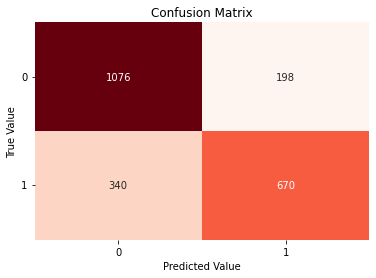

In [38]:
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

In [39]:
mdl.save("./")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets
